**In this notebook we try to classify x-ray images of lungs to check if the patient has pneumonia or not.**

**[The dataset](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).**

**Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.**

**For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.**

#1.   Importing libraries

I use GoogleColab with TPU acceleration and before we start we should select tensorflow v2.1.


In [0]:
%tensorflow_version 2.x

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import io
%matplotlib inline

#2.   Importing and exploring the dataset

I uploaded the data into my googledrive. So we should mount gdrive to access the files.

In [0]:
from google.colab import drive
drive.mount('/gdrive')

In [0]:
with open('/gdrive/My Drive/foo.txt', 'w') as f:
  f.write('Hello Google Drive!')
!cat '/gdrive/My Drive/foo.txt'

The following command unzips the file.

In [0]:
!unzip '/content/drive/My Drive/kaggle data/lungs/chest-xray-pneumonia.zip' 

Archive:  /content/drive/My Drive/kaggle data/lungs/chest-xray-pneumonia.zip
replace chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


Let's check the data directory.

In [0]:
my_data_dir = '/content/chest_xray'

In [0]:
os.listdir(my_data_dir) 

['train', '__MACOSX', 'chest_xray', 'test', 'val']

In [0]:
test_path = my_data_dir+'/test/'
train_path = my_data_dir+'/train/'
val_path = my_data_dir+'/val/'

In [0]:
os.listdir(test_path)

['PNEUMONIA', 'NORMAL']

In [0]:
os.listdir(train_path)

['PNEUMONIA', 'NORMAL']

In [0]:
os.listdir(val_path)

['PNEUMONIA', 'NORMAL']

Let's check how the images look in the training set.

In [0]:
para_img= io.imread(train_path+'NORMAL/'+os.listdir(train_path+'NORMAL')[1], as_gray=True)

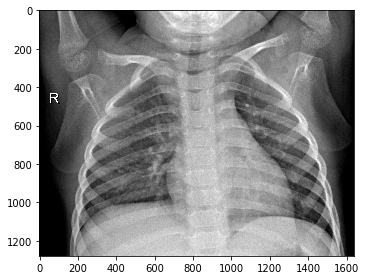

In [0]:
io.imshow(para_img)

In [0]:
para_img.shape # Image shape.

(1279, 1638)

In [0]:
len(os.listdir(train_path+'/NORMAL')) # The number of images in the NORMAL category.

1341

In [0]:
len(os.listdir(train_path+'/PNEUMONIA')) # The number of images in the PNEUMONIA category.

3875

Let's check the minimum dimensions of the images.

In [0]:
from skimage import io
dim1 = []
dim2 = []
for image_filename in os.listdir(train_path+'NORMAL'):
    
    img = io.imread(train_path+'NORMAL/'+image_filename)
    d1,d2 = img.shape
    dim1.append(d1)
    dim2.append(d2)

In [0]:
np.min(dim1)

672

In [0]:
np.min(dim2)

912

Because of the limitation of resources we have to reshape images into a smaller dimesnions. That might decrease the accuracy of the model a bit.

In [0]:
unified_shape = (128,192,3)

Let's check how images in the pneumonia category looks.

In [0]:
para_img= io.imread(train_path+'PNEUMONIA/'+os.listdir(train_path+'PNEUMONIA')[20],as_gray=True)

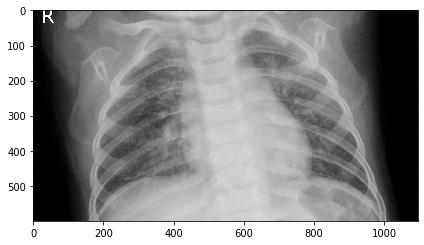

In [0]:
io.imshow(para_img)

In [0]:
para_img.shape # Image shape.

(600, 1096)

We are going to use ImageDataGenerator to add distortion. Image Augmentation is the process of taking images that are already in a training dataset and manipulating them to create many altered versions of the same image. That makes the model more robust.

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
train_image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                               ,samplewise_std_normalization=True,samplewise_center=True) # Allow sample wise normalization and centring
test_image_gen = ImageDataGenerator(samplewise_std_normalization=True,samplewise_center=True)
val_image_gen = ImageDataGenerator(samplewise_std_normalization=True,samplewise_center=True)

Flow_from_directory used to import images directly from a predefined directory.

In [0]:
train_image_gen.flow_from_directory(train_path)

Found 5216 images belonging to 2 classes.


In [0]:
test_image_gen.flow_from_directory(test_path)

Found 624 images belonging to 2 classes.


In [0]:
val_image_gen.flow_from_directory(val_path)

Found 16 images belonging to 2 classes.


#3.   Building the model

To activate tpus we must use the following lines.

In [0]:
import tensorflow as tf
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)


INFO:tensorflow:Initializing the TPU system: grpc://10.48.181.194:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.48.181.194:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

Now we will add 3 conventional layers , then add a flatten layer , a dense layer with dropout rate of 0.5 (Drop out turnsoff a fixed percentage every batch). Finally we will use sigmoid to get the results.

In [0]:

strategy = tf.distribute.experimental.TPUStrategy(resolver)
with strategy.scope():


  model = Sequential()

  model.add(Conv2D(filters=32, kernel_size=(7,7),input_shape=unified_shape, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=unified_shape, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=unified_shape, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))


  model.add(Flatten())


  model.add(Dense(128))
  model.add(Activation('relu'))

  model.add(Dropout(0.5))

  model.add(Dense(1))
  model.add(Activation('sigmoid'))

  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [0]:
model.summary() # The neural network summary.

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 122, 186, 32)      4736      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 61, 93, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 59, 91, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 29, 45, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 27, 43, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 13, 21, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 17472)            

In [0]:
from tensorflow.keras.callbacks import EarlyStopping

Early stopping stops the training process when value we are monitoring doesn't decrease for a number of batches. Fore our model we will monitor validation loss and wait 2 batches before stopping the model.

In [0]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

Here we must set batch size as the number of images in each directory.

In [0]:
train_image_gen = train_image_gen.flow_from_directory(train_path,
                                               target_size=unified_shape[:2],
                                                color_mode='rgb',
                                               batch_size=5216,
                                               class_mode='binary')

Found 5216 images belonging to 2 classes.


In [0]:
test_image_gen = test_image_gen.flow_from_directory(test_path,
                                               target_size=unified_shape[:2],
                                               color_mode='rgb',
                                               batch_size=624,
                                               class_mode='binary',shuffle=False)

Found 624 images belonging to 2 classes.


In [0]:
val_image_gen = val_image_gen.flow_from_directory(val_path,
                                               target_size=unified_shape[:2],
                                               color_mode='rgb',
                                               batch_size=16,
                                               class_mode='binary',shuffle=False)

Found 16 images belonging to 2 classes.


In [0]:
Now we must split the images into x and y datasets.

In [0]:
X_train, y_train = train_image_gen.next()
X_test, y_test = test_image_gen.next()
X_val, y_val = val_image_gen.next()

In [0]:
train_image_gen.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
model.fit(X_train,y_train,epochs=500,
                              validation_data=(X_val,y_val),
                             callbacks=[early_stop])

Epoch 1/500
163/163 [==============================] - 7s 43ms/step - loss: 0.4608 - accuracy: 0.7786 - val_loss: 0.7870 - val_accuracy: 0.6875
Epoch 2/500
163/163 [==============================] - 4s 24ms/step - loss: 0.3282 - accuracy: 0.8620 - val_loss: 0.5544 - val_accuracy: 0.5625
Epoch 3/500
163/163 [==============================] - 4s 24ms/step - loss: 0.2754 - accuracy: 0.8875 - val_loss: 0.4923 - val_accuracy: 0.8125
Epoch 4/500
163/163 [==============================] - 4s 24ms/step - loss: 0.2393 - accuracy: 0.9103 - val_loss: 0.4354 - val_accuracy: 0.8125
Epoch 5/500
163/163 [==============================] - ETA: 0s - loss: 0.1989 - accuracy: 0.9283WARNING:tensorflow:5 out of the last 5 calls to <function Model.make_test_function.<locals>.test_function at 0x7f29cf597268> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True

163/163 [==============================] - 5s 28ms/step - loss: 0.1989 - accuracy: 0.9283 - val_loss: 0.5056 - val_accuracy: 0.7500
Epoch 6/500
163/163 [==============================] - ETA: 0s - loss: 0.1843 - accuracy: 0.9337WARNING:tensorflow:6 out of the last 6 calls to <function Model.make_test_function.<locals>.test_function at 0x7f29cf597268> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


163/163 [==============================] - 4s 25ms/step - loss: 0.1843 - accuracy: 0.9337 - val_loss: 0.5125 - val_accuracy: 0.7500


#4.   Evaluating the model results.

In [0]:
losses = pd.DataFrame(model.history.history)

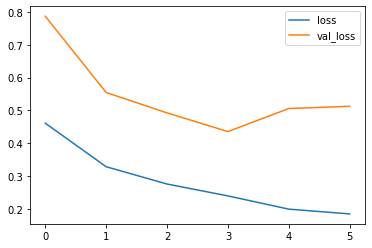

In [0]:
losses[['loss','val_loss']].plot() # loss plot

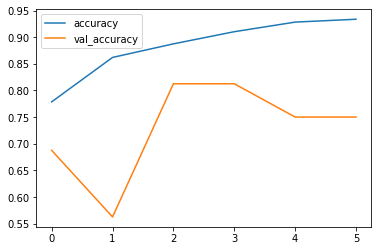

In [0]:
losses[['accuracy','val_accuracy']].plot() # accuracy plot

#5.   Predicting the test set.

In [0]:
pred_probabilities = model.predict(X_test)

The values we have here are the probabilities which varries from 0 to 1.

In [0]:
pred_probabilities

array([[0.5596579 ],
       [0.5078775 ],
       [0.8262192 ],
       [0.8624947 ],
       [0.606114  ],
       [0.1576652 ],
       [0.78957355],
       [0.907526  ],
       [0.78742397],
       [0.8206502 ],
       [0.51042455],
       [0.78668916],
       [0.45692316],
       [0.60664743],
       [0.55529535],
       [0.56149507],
       [0.99915236],
       [0.8630919 ],
       [0.27623215],
       [0.47363842],
       [0.6393266 ],
       [0.76572406],
       [0.7353033 ],
       [0.56447697],
       [0.7315566 ],
       [0.7082611 ],
       [0.98412216],
       [0.2434634 ],
       [0.37259397],
       [0.544594  ],
       [0.56350875],
       [0.4934231 ],
       [0.5777623 ],
       [0.41402653],
       [0.7485369 ],
       [0.20729002],
       [0.03478596],
       [0.6164101 ],
       [0.24439284],
       [0.03957468],
       [0.96023536],
       [0.33294845],
       [0.11726874],
       [0.08581728],
       [0.6925193 ],
       [0.95511746],
       [0.9028264 ],
       [0.842

In [0]:
test_image_gen.classes #The real classes of the images

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

Now to make the final predictions we must set a fixed value which is the confidence value of the preciction. If the probability is over this value we will classiy the image as Pneumonia infected. Otherwise it's normal.

In [0]:
predictions = pred_probabilities > 0.9

In [0]:
predictions

array([[False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [

Even though it's boolean values(True and false), the classification_report and confusion_matrix will interpret True as 1 and False as 0.

In [0]:
from sklearn.metrics import classification_report,confusion_matrix

In [0]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

         0.0       0.86      0.83      0.85       234
         1.0       0.90      0.92      0.91       390

    accuracy                           0.89       624
   macro avg       0.88      0.87      0.88       624
weighted avg       0.89      0.89      0.89       624



In [0]:
confusion_matrix(y_test,predictions)

array([[194,  40],
       [ 31, 359]])

As we can see we trained a model which was able to predict Pneumonia presence with accuracy of 0.89 percent using CNN.

We can save the model for later by using the following line.

In [0]:
from tensorflow.keras.models import load_model
model.save('malaria_detector.h5')